## Language Analysis of Alexithymic Discourse

<hr>

Alexithymic Language Project / raul@psicobotica.com / V2 release (sept 2020)

<hr>

### Latent Semantic Analysis (LSA)

We perform a Latent Semantic analysis to find relationships between documents and terms they contain. Basically, we perform a LSA-based topic detection to find out whether alexithymic language differs in topics from non-alexithymic language when referred to the same stimuli.

LSA takes into account context around words to determine topics. LSA uses Singular-Value Decomposition (SVD) for dimensionality reduction of document vectors. 

- Topic modeling. 

<hr>

[More about Latent Semantic Analysis](https://en.wikipedia.org/wiki/Latent_semantic_analysis)

[About Singular-Value Decomposition](https://en.wikipedia.org/wiki/Singular_value_decomposition)


In [1]:
import pandas as pd 
import numpy as np
import ast

## Load features dataset
- Data is already pre-processed (1-Preprocessing). 
- Basic NLP features are already calculated (2-Features). 
- Some additional BoW features have been added (3-BoW).
- Some additional TF/IDF features have been added (3-TFIDF).
- N-Gram models have been generated (3-N-Grams). 
- PoS lists for each document identified (4-Lexicosemantics). 
- Writer's personality variables inferred (5-Personality).
- Sentiment analysis (6-Sentiment). 

In [2]:
feats_dataset_path = "https://raw.githubusercontent.com/raul-arrabales/alexithymic-lang/master/data/Prolexitim_v2_features_6.csv"
alex_df = pd.read_csv(feats_dataset_path, header=0, delimiter=";")

In [3]:
alex_df.sample(2)

,Code,TAS20,F1,F2,F3,Gender,Age,Card,T_Metaphors,T_ToM,...,consumption_preferences_volunteer,MSP_Words,MSP_Stems,AFINN_Words_Pol,AFINN_Stems_Pol,AFINN_Words_Int,AFINN_Stems_Int,AFINN_Words_Max,AFINN_Stems_Max,Watson_Sent
216,0496b449d5006fe4c1bcc37a208a0e00,41,13,10,18,2,56,9VH,0,1,...,0.0,0.047619,0.190476,8,8,4.0,4.0,8,8,0.759027
115,efb2088a8ab28dc16c158813ae396ec8,35,13,9,13,2,29,13HM,0,1,...,0.0,-0.111111,-0.222222,-5,1,3.5,0.5,6,1,-0.976379


In [4]:
alex_df.columns[0:40]

Index(['Code', 'TAS20', 'F1', 'F2', 'F3', 'Gender', 'Age', 'Card',
       'T_Metaphors', 'T_ToM', 'T_FP', 'T_Interpret', 'T_Desc', 'T_Confussion',
       'Text', 'Alex_A', 'Alex_B', 'Words', 'Sentences', 'Tokens',
       'Tokens_Stop', 'Tokens_Stem_P', 'Tokens_Stem_S', 'POS', 'NER', 'DEP',
       'Lemmas_CNLP', 'Lemmas_Spacy', 'Chars', 'avgWL', 'avgSL', 'Pun_Count',
       'Stop_Count', 'RawTokens', 'Title_Count', 'Upper_Count', 'PRON_Count',
       'DET_Count', 'ADV_Count', 'VERB_Count'],
      dtype='object')

## Stimuli variable (card) control
- Remove under-represented cards

In [5]:
alex_df.Card.value_counts()

9VH     89
1       85
11      83
13HM    81
12VN     8
7VH      6
3VH      6
13N      5
13V      5
10       4
18NM     3
13VH     2
15HM     1
10N      1
9BM      1
!·HM     1
Name: Card, dtype: int64

In [6]:
# drop under-represented cards
alex_df = alex_df.drop(alex_df[(alex_df.Card != '9VH') & (alex_df.Card != '1') & (alex_df.Card != '11') & (alex_df.Card != '13HM')].index)

In [7]:
alex_df.Card.value_counts()

9VH     89
1       85
11      83
13HM    81
Name: Card, dtype: int64

## LSA analysis

### Document-Term matrix 
- TF/IDF vector per document

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer 

In [9]:
# Get TF/IDF vectors for each doc
TFIDF_vectorizer = TfidfVectorizer(max_features= 1000, # Top 1K most frequent word in the dict
                                   max_df = 0.5,      # Maximum Document Frequency
                                   smooth_idf=True)   # Adds 1 extra doc to prevent zero div

In [10]:
# Get a new column with removed stop words in Spanish
# As sklearn RF/IDF vectorizer does not support Spanish
alex_df['Clean_Text'] = alex_df.Tokens_Stop.apply(lambda x: " ".join(ast.literal_eval(x)))

In [11]:
alex_df[['Text', 'Tokens_Stop','Clean_Text']].sample(4)

,Text,Tokens_Stop,Clean_Text
228,"Después de un largo día de trabajo, llegó la p...","['después', 'largo', 'día', 'trabajo', 'llegó'...",después largo día trabajo llegó plácida siesta...
253,Vaya resaca más mala! Anoche el Rubius se bebi...,"['vaya', 'resaca', 'mala', 'anoche', 'rubius',...",vaya resaca mala anoche rubius bebió jarabe to...
301,un niño que quería tocar el violín pero sus pa...,"['niño', 'quería', 'tocar', 'violín', 'padres'...",niño quería tocar violín padres permitían cost...
174,"El doctor solo pudo certificar su muerte, esta...","['doctor', 'solo', 'pudo', 'certificar', 'muer...",doctor solo pudo certificar muerte agotado des...


In [12]:
TFIDF_matrix = TFIDF_vectorizer.fit_transform(alex_df['Clean_Text'])

In [13]:
print("We have %d documents and %d most frequent terms." % 
      (TFIDF_matrix.shape[0],TFIDF_matrix.shape[1]))

We have 338 documents and 1000 most frequent terms.


### Topic modeling

In [14]:
from sklearn.decomposition import TruncatedSVD

In [15]:
# Number of topics to detect
NUM_Topics = 4 # same as different stimuli. 

In [16]:
# SVD represent documents and terms in vectors 
SVD_model = TruncatedSVD(
    n_components=NUM_Topics, 
    algorithm='randomized', 
    n_iter=100, 
    random_state=122)

In [25]:
SVD_model.fit(TFIDF_matrix)

TruncatedSVD(algorithm='randomized', n_components=4, n_iter=100,
       random_state=122, tol=0.0)

In [19]:
len(SVD_model.components_)

4

In [20]:
# Inspect topics detected

terms = TFIDF_vectorizer.get_feature_names()

for i,comp in enumerate(SVD_model.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
    words = []
    for t in sorted_terms:
        words.append(t[0])        
    print("Topic " + str(i) + ": " + str(words))
    

Topic 0: ['niño', 'violín', 'tocar', 'padres', 'aburrido', 'quería', 'violin']
Topic 1: ['hombre', 'mujer', 'muerta', 'cama', 'esposa', 'llorando', 'fallecida']
Topic 2: ['día', 'grupo', 'hombres', 'descansando', 'siesta', 'después', 'campo']
Topic 3: ['cascada', 'bosque', 'montaña', 'camino', 'animales', 'pájaros', 'agua']


Topics clearly match the typical description of the four cards:

<img src="https://psicobotica.com/prolexitim/nlp/stimuli/TAT-1.jpg" align="left" width=160>

<img src="https://psicobotica.com/prolexitim/nlp/stimuli/TAT-9VH.jpg" align="left" width=160> 

<img src="https://psicobotica.com/prolexitim/nlp/stimuli/TAT-11.jpg" align="left" width=160> 

<img src="https://psicobotica.com/prolexitim/nlp/stimuli/TAT-13HM.jpg" align="left" width=160>


### Topic Visualization
- 2D projection using UMAP

[About UMAP - Uniform Manifold Approximation and Projection](https://arxiv.org/abs/1802.03426)

[API docs](https://umap-learn.readthedocs.io/en/latest/)

In [ ]:
# ! pip uninstall umap

In [ ]:
# ! pip install llvmlite --ignore-installed

In [100]:
# ! pip install umap-learn --user

Processing c:\users\array\appdata\local\pip\cache\wheels\14\9a\ed\66159a5e13d3b6341b6542cf4f1faf478834753bed5ecaef8d\umap_learn-0.4.6-py3-none-any.whl
  Using cached numba-0.51.2-cp37-cp37m-win_amd64.whl (2.2 MB)


In [21]:
import umap
# import umap.umap as umap

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
topics = SVD_model.fit_transform(TFIDF_matrix)

In [28]:
embedding = umap.UMAP(
    n_neighbors=150, 
    min_dist=0.5, 
    random_state=12).fit_transform(topics)

In [34]:
embedding.shape

(338, 2)

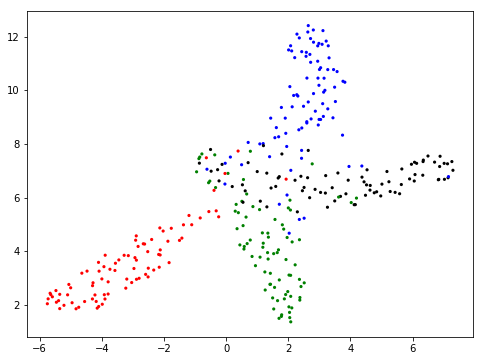

In [38]:
colors = {'9VH': 'blue', '1': 'red', '11': 'green', '13HM': 'black'}

plt.figure(figsize=(8,6))
plt.scatter(
    embedding[:, 0], 
    embedding[:, 1], 
    c = alex_df['Card'].apply(lambda x: colors[x]),
    #c = ['green','blue','black','red'],
    s = 10, # size
    edgecolor='none'
)
plt.show()